# Example 1 - Refactored

### Proposed task
**Dataset**: We have a set of images, with file names in the following format: month_x_band_y.tif, where x is the month and y is the band name (Example: month_1_band_B02.tif).

The code must be able to:
- Create, for each band, a stack of monthly images.
- Create vegetation indices for each image.
- Create time composites for each band (e.g. median, mean, maximum, minimum).
- Plot the vegetation indices (single-band plot) and RGB composites (three-band plot) for the time composites.
- Export the time composites as GeoTIFF files.

### Initial implementation
The initial implmentation (notebook `example.ipynb`) provides a simple code to implement the proposed task. However, it does not have a structured code and does not allow us to to change configurations easily. For example, if we add a new vegetation index, we need to make several changes in the code to create a time composite of this new index, plot it and export it.

### Refactored implementation
This notebook provides a refactored code for the proposed task. 
Here we rely on a package named `mygeopackage` that contains the code to implement each step of the proposed task in a structured way. The code in this notebook is now only responsible for calling the functions from the package and setting the desired configurations.
The code implemented in this refactored version was built around the following data structures:
- `GeoParams`: it is a class that stores the geospatial attributes of the images (crs, transform and nodata).
- `ImageStack`: it is a class that stores a stack of images and their geostatial attributes (GeoParams). It also provides methods to add check the available bands, get data from a specific band, and export data from a band as a GeoTIFF file.
- `BandName`: it is an enumeration that stores the band names. By using it, if we change the band names, we only need to change the enumeration and the code will be updated automatically. This kind of approach is useful to avoid having to change the code in several places when we need to update some configuration.

Since raster data have multiple bands, dates, and georrefferencing information, by creating the data structures above, we can simplify the way that we manage the data. You spend more time to create but after that, you have a code much more flexible and easy to maintain.

The code implemented in the package have the following files:
- `__init__.py`: Initializes the package. It is empty in this case. Overall, we always add this file to the package and subpackages.
- `data_structures.py`: Contains the data structures `GeoParams`, `ImageStack` and `BandName`.
- `data_loader.py`: Create a class `ImageScanner` responsible for scanning the images and retrieving their paths and metadata (month and band). In this module, we also have a function to load/stack the images and return the result as an `ImageStack` object.
- `vegetation_indices.py`: Contains the functions to add vegetation indices to an `ImageStack` object.
- `stack_operations.py`: Contains the function to create time composites and a function to plot data. Note that the funtion used to create time composites (`apply_reduction`) is a generic function that can be used to create any kind of time composite based on numpy functions. Thus, with an ImageStack object called stack, you can use like `apply_reduction(stack, np.mean)` to create a mean composite, `apply_reduction(stack, np.median)` to create a median composite, and so on.

In [1]:
import numpy as np

from mygeopackage import data_loader, vegetation_indices as vi, stack_operations
from mygeopackage.data_structures import BandName

In [2]:
DATA_FOLDER = '../data/example_images/'
EXPORT_FOLDER = './processed_data_refactored/'

In [16]:
# Scan the data folder for images
scanner = data_loader.ImageScanner(DATA_FOLDER)
scan_results = scanner.scan()
scan_results.head(5)

,month,band,file_path
0,1,B02,..\data\example_images\1\month_1_band_B02.tif
1,1,B03,..\data\example_images\1\month_1_band_B03.tif
2,1,B04,..\data\example_images\1\month_1_band_B04.tif
3,1,B08,..\data\example_images\1\month_1_band_B08.tif
4,2,B02,..\data\example_images\2\month_2_band_B02.tif


In [15]:
# Create a stack of the images with data from the selected months
month_stack = data_loader.stack_months(scan_results, target_months = [7,8,9,10])

In [5]:
month_stack.get_available_bands()

['B02', 'B03', 'B04', 'B08']

In [17]:
month_stack.get_band_stack('B02').shape

(4, 512, 512)

In [6]:
# Add some vegetation indices to the stack
vi.add_nvdi(month_stack)
vi.add_evi(month_stack)

In [7]:
month_stack.get_available_bands()

['B02', 'B03', 'B04', 'B08', 'NDVI', 'EVI']

In [9]:
# Create some reduced stacks
reduced_stack_mean = stack_operations.apply_reduction(month_stack, np.nanmean, axis=0)
reduced_stack_max = stack_operations.apply_reduction(month_stack, np.nanmax, axis=0)

In [10]:
reduced_stack_mean.get_band_stack('NDVI').shape

(1, 512, 512)

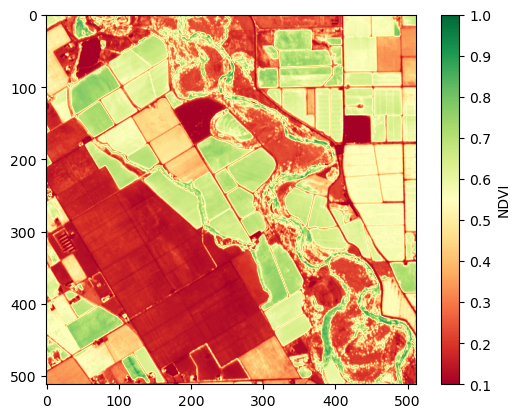

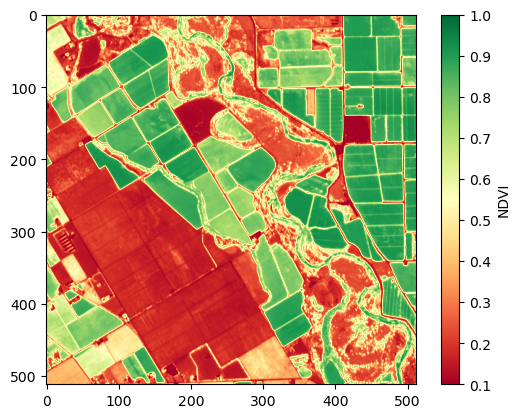

In [11]:
# Single-band plots
stack_operations.plot_stack(reduced_stack_mean, 'NDVI', cmap='RdYlGn', vmin=0.1, vmax=1)
stack_operations.plot_stack(reduced_stack_max, 'NDVI', cmap='RdYlGn', vmin=0.1, vmax=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


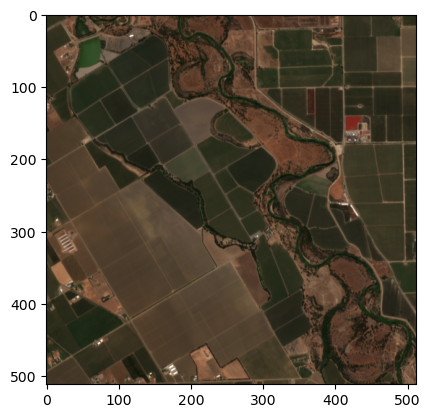

In [12]:
# True-color plot
stack_operations.plot_stack(reduced_stack_mean, [BandName.RED.value, BandName.GREEN.value, BandName.BLUE.value])

In [13]:
# Exporting to GeoTiff
export_bands = ['NDVI', 'EVI']
for band in export_bands:
    reduced_stack_mean.export_band(band=band, file_path=EXPORT_FOLDER + f'{band}_mean.tif')
    
for band in export_bands:
    reduced_stack_max.export_band(band=band, file_path=EXPORT_FOLDER + f'{band}_max.tif')